In [3]:
import requests
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import dotenv_values
import sqlite3
import sqlite_utils
import time
import statistics
import dash
import plotly.express as px


In [4]:
mid_kr_puuid = "yke-_ZuAP9wM6s3tpe-FnVWLlnwI4qLuLRzz933HfpI_jzKcDa1YwXbWGpFC7WJek_rv4x_kXk2Y-A"
faker_puuid = "HD9jtPc4kBf9qCfY6YjeqjnirqDqnwyugRPRg52DqZ8bmVVLbK7Gst0fA5vpYcPHUS95nxbmdNe5YA"

In [5]:
conn = sqlite3.connect('koren_soloq_db.db')
cursor = conn.cursor()
match_end_data = cursor.execute('''SELECT metadata, info FROM MATCH_DATA''').fetchall()
match_timeline_data = cursor.execute('''SELECT metadata, timelineinfo FROM MATCH_DATA''').fetchall()

faker_match_end_data = cursor.execute('''SELECT metadata, info FROM MATCH_DATA_FAKER''').fetchall()
faker_match_timeline_data = cursor.execute('''SELECT metadata, timelineinfo FROM MATCH_DATA_FAKER''').fetchall()

conn.close()

qing init

In [6]:
#Filter only mid role games
list_match_end_data_whereMid = []
mid_matchs = []
for idx_match, match in enumerate(match_end_data) :
    match_info = json.loads(match[1])
    for idx, participant in enumerate(match_info['participants']):
        if (participant['puuid'] == mid_kr_puuid) and (participant['teamPosition'] == "MIDDLE"):
            list_match_end_data_whereMid.append(match)
            mid_matchs.append(idx_match)

list_match_timeline_data_whereMid = [match_timeline_data[i] for i in mid_matchs]

faker init

In [7]:
#Filter only mid role games
faker_list_match_end_data_whereMid = []
faker_mid_matchs = []
for idx_match, match in enumerate(faker_match_end_data) :
    faker_match_info = json.loads(match[1])
    for idx, participant in enumerate(faker_match_info['participants']):
        if (participant['puuid'] == faker_puuid) and (participant['teamPosition'] == "MIDDLE"):
            faker_list_match_end_data_whereMid.append(match)
            faker_mid_matchs.append(idx_match)

faker_list_match_timeline_data_whereMid = [faker_match_timeline_data[i] for i in faker_mid_matchs]

In [148]:
print("Taille bdd :", len(match_end_data))
print("Tailles bdd only mid :" , len(list_match_end_data_whereMid))
print("Tailles bdd only mid :" , len(list_match_timeline_data_whereMid))

Taille bdd : 600
Tailles bdd only mid : 505
Tailles bdd only mid : 505


In [151]:
print("Taille bdd :" , len(faker_match_end_data))
print("Taille bdd only mid :" , len(faker_list_match_end_data_whereMid))
print("Taille bdd only mid :", len(faker_list_match_timeline_data_whereMid))

Taille bdd : 457
Taille bdd only mid : 399
Taille bdd only mid : 399


In [10]:
def is_forward(x, y , side) :
    a = -1
    b = 16000 - a* 0

    y_diag = a * x+b

    if side == 100: #blue side
        if y > y_diag :
            return True
        else :
            return False
    if side == 200 : #Red side, on inverse alors
        if y > y_diag :
            return False
        else :
            return True

In [19]:
def qing_to_df():
    df = pd.DataFrame()

    for match in list_match_end_data_whereMid :
        match_metadata = json.loads(match[0])
        match_id = match_metadata['matchId']
        for idx, player_puuid in enumerate(match_metadata['participants']):
            if player_puuid == mid_kr_puuid:
                index_qing = idx

        match_info = json.loads(match[1])

        game_duration = match_info['gameDuration']
        
        #KDA
       
        kills = match_info['participants'][index_qing]['kills']
        assists = match_info['participants'][index_qing]['assists']
        deaths = match_info['participants'][index_qing]['deaths']
        if deaths == 0 : deaths = 1

        #CS/MIN
        monster_cs = match_info['participants'][index_qing]['neutralMinionsKilled']
        minion_cs = match_info['participants'][index_qing]['totalMinionsKilled']


        #Champions les plus joués
        champion = match_info['participants'][index_qing]['championName']

        #Win 
        win = match_info['participants'][index_qing]['win']



        currentGame = pd.DataFrame([[champion,kills,assists,deaths,(kills+assists)/deaths,(monster_cs + minion_cs) /  (game_duration//60),game_duration, win]], columns=['champion','kills','assists','deaths','kda','cs/min','game_duration','win'],index=[match_id])
        df = pd.concat([df,currentGame])
    return df
qing_to_df()

,champion,kills,assists,deaths,kda,cs/min,game_duration,win
KR_7329575443,Orianna,3,12,5,3.000000,7.807692,1564,False
KR_7329546409,Hwei,2,16,4,4.500000,8.280000,1509,True
KR_7329493150,Tristana,9,6,9,1.666667,6.714286,1686,False
KR_7329479027,Sylas,3,5,1,8.000000,7.733333,913,True
KR_7329444912,Xerath,9,11,4,5.000000,7.766667,1846,True
...,...,...,...,...,...,...,...,...
KR_7223353740,Smolder,10,11,5,4.200000,7.793103,1758,True
KR_7219217995,Smolder,6,10,7,2.285714,7.939394,2010,True
KR_7219171692,Smolder,3,4,1,7.000000,9.933333,915,True
KR_7219121163,Smolder,4,5,1,9.000000,10.157895,1177,True


In [20]:
def faker_to_df():

    df = pd.DataFrame()

    for match in faker_list_match_end_data_whereMid :
        match_metadata = json.loads(match[0])
        match_id = match_metadata['matchId']
        for idx, player_puuid in enumerate(match_metadata['participants']):
            if player_puuid == faker_puuid:
                index_faker = idx

        match_info = json.loads(match[1])

        game_duration = match_info['gameDuration']
        game_id = match_info['gameId']
        #KDA
       
        kills = match_info['participants'][index_faker]['kills']
        assists = match_info['participants'][index_faker]['assists']
        deaths = match_info['participants'][index_faker]['deaths']
        if deaths == 0 : deaths = 1

        #CS/MIN
        monster_cs = match_info['participants'][index_faker]['neutralMinionsKilled']
        minion_cs = match_info['participants'][index_faker]['totalMinionsKilled']


        #Champions les plus joués
        champion = match_info['participants'][index_faker]['championName']

        #Win 
        win = match_info['participants'][index_faker]['win']



        currentGame = pd.DataFrame([[champion,kills,assists,deaths,(kills+assists)/deaths,(monster_cs + minion_cs) /  (game_duration//60),game_duration, win]], columns=['champion','kills','assists','deaths','kda','cs/min','game_duration','win'],index=[match_id])
        df = pd.concat([df,currentGame])
    return df
faker_to_df()

,champion,kills,assists,deaths,kda,cs/min,game_duration,win
KR_7277245614,Ziggs,3,8,2,5.500000,8.478261,1414,True
KR_7277191080,Yone,2,4,7,0.857143,8.629630,1670,False
KR_7277107558,Tristana,7,5,4,3.000000,9.533333,1845,True
KR_7277064011,Smolder,3,1,1,4.000000,10.200000,914,True
KR_7276973233,Smolder,4,4,6,1.333333,9.730769,1612,False
...,...,...,...,...,...,...,...,...
KR_6926873782,TwistedFate,4,4,4,2.000000,7.809524,1295,True
KR_6926509000,Ekko,1,6,4,1.750000,7.666667,1291,True
KR_6926493212,Ekko,6,6,1,12.000000,10.500000,1123,True
KR_6926456239,TwistedFate,10,1,5,2.200000,7.444444,1635,False


In [21]:
def qing_timeline(qing_df):
    list_matchId = []
    list_side = []
    list_forward = []
    list_golddiff = []
 
    for matchIndex, match in enumerate(list_match_timeline_data_whereMid):
        time_forward = []

        match_metadata = json.loads(match[0])
        list_matchId.append(match_metadata['matchId'])
        for idx, player_puuid in enumerate(match_metadata['participants']):
            if player_puuid == mid_kr_puuid:
                index_qing = idx
     
        for idx, participant in enumerate(json.loads(list_match_end_data_whereMid[matchIndex][1])['participants']):
            if (participant['teamPosition'] == "MIDDLE") and (participant['puuid']) != mid_kr_puuid:
                index_ennemy = idx
                side_ennemy = participant['teamId']
                if side_ennemy == 100 : 
                    side_qing = 200 
                    list_side.append(side_qing)
                else : 
                    side_qing = 100
                    list_side.append(side_qing)
            

        match_info = json.loads(match[1])
        
        if len(match_info['frames']) > 16 :
            qing_gold_15 = match_info['frames'][15]['participantFrames'][str(index_qing+1)]['totalGold']
            ennemy_gold_15 = match_info['frames'][15]['participantFrames'][str(index_ennemy+1)]['totalGold']
            list_golddiff.append((qing_gold_15- ennemy_gold_15))
        else :
            list_golddiff.append(None)

        for frame in match_info['frames'] :  
            x = frame['participantFrames'][str(index_qing+1)]['position']['x']
            y = frame['participantFrames'][str(index_qing+1)]['position']['y']

            time_forward.append(is_forward(x,y,side_qing))
        list_forward.append(statistics.mean(time_forward))
    
    current_game = pd.DataFrame({'ally_side' : list_side,'forward_%' : list_forward, 'gold_diff@15' : list_golddiff} ,index=list_matchId)
    qing_df = qing_df.merge(current_game, left_index=True, right_index=True, how='left')

    return qing_df
data = qing_timeline(qing_to_df())
data

,champion,kills,assists,deaths,kda,cs/min,game_duration,win,ally_side,forward_%,gold_diff@15
KR_7329575443,Orianna,3,12,5,3.000000,7.807692,1564,False,100,0.000000,284.0
KR_7329546409,Hwei,2,16,4,4.500000,8.280000,1509,True,200,0.592593,-1193.0
KR_7329493150,Tristana,9,6,9,1.666667,6.714286,1686,False,200,0.400000,1695.0
KR_7329479027,Sylas,3,5,1,8.000000,7.733333,913,True,100,0.235294,904.0
KR_7329444912,Xerath,9,11,4,5.000000,7.766667,1846,True,100,0.125000,1367.0
...,...,...,...,...,...,...,...,...,...,...,...
KR_7223353740,Smolder,10,11,5,4.200000,7.793103,1758,True,200,0.709677,-397.0
KR_7219217995,Smolder,6,10,7,2.285714,7.939394,2010,True,100,0.257143,-595.0
KR_7219171692,Smolder,3,4,1,7.000000,9.933333,915,True,100,0.294118,-399.0
KR_7219121163,Smolder,4,5,1,9.000000,10.157895,1177,True,100,0.333333,-291.0


In [49]:
def faker_timeline(faker_df):
    list_matchId = []
    list_side = []
    list_forward = []
    list_golddiff = []
 
    for matchIndex, match in enumerate(faker_list_match_timeline_data_whereMid):
        time_forward = []

        match_metadata = json.loads(match[0])
        list_matchId.append(match_metadata['matchId'])
        for idx, player_puuid in enumerate(match_metadata['participants']):
            if player_puuid == faker_puuid:
                index_faker = idx
     
        for idx, participant in enumerate(json.loads(faker_list_match_end_data_whereMid[matchIndex][1])['participants']):
            if (participant['teamPosition'] == "MIDDLE") and (participant['puuid']) != faker_puuid:
                index_ennemy = idx
                side_ennemy = participant['teamId']
                if side_ennemy == 100 : 
                    side_faker = 200 
                    list_side.append(side_faker)
                else : 
                    side_faker = 100
                    list_side.append(side_faker)
            

        match_info = json.loads(match[1])
        
        if len(match_info['frames']) > 16 :
            faker_gold_15 = match_info['frames'][15]['participantFrames'][str(index_faker+1)]['totalGold']
            ennemy_gold_15 = match_info['frames'][15]['participantFrames'][str(index_ennemy+1)]['totalGold']
            list_golddiff.append((faker_gold_15- ennemy_gold_15))
        else :
            list_golddiff.append(None)

        for frame in match_info['frames'] :  
            x = frame['participantFrames'][str(index_faker+1)]['position']['x']
            y = frame['participantFrames'][str(index_faker+1)]['position']['y']

            time_forward.append(is_forward(x,y,side_faker))
        list_forward.append(statistics.mean(time_forward))
    
    current_game = pd.DataFrame({'ally_side' : list_side,'forward_%' : list_forward, 'gold_diff@15' : list_golddiff} ,index=list_matchId)
    faker_df = faker_df.merge(current_game, left_index=True, right_index=True, how='left')

    return faker_df
faker_data = faker_timeline(faker_to_df())
faker_data

,champion,kills,assists,deaths,kda,cs/min,game_duration,win,ally_side,forward_%,gold_diff@15
KR_7277245614,Ziggs,3,8,2,5.500000,8.478261,1414,True,100,0.280000,803.0
KR_7277191080,Yone,2,4,7,0.857143,8.629630,1670,False,100,0.103448,-943.0
KR_7277107558,Tristana,7,5,4,3.000000,9.533333,1845,True,100,0.156250,-583.0
KR_7277064011,Smolder,3,1,1,4.000000,10.200000,914,True,100,0.058824,1988.0
KR_7276973233,Smolder,4,4,6,1.333333,9.730769,1612,False,100,0.071429,-179.0
...,...,...,...,...,...,...,...,...,...,...,...
KR_6926873782,TwistedFate,4,4,4,2.000000,7.809524,1295,True,200,0.652174,638.0
KR_6926509000,Ekko,1,6,4,1.750000,7.666667,1291,True,200,0.739130,-355.0
KR_6926493212,Ekko,6,6,1,12.000000,10.500000,1123,True,100,0.250000,1557.0
KR_6926456239,TwistedFate,10,1,5,2.200000,7.444444,1635,False,200,0.551724,1538.0


### Position tests

In [147]:
json.loads(list_match_timeline_data_whereMid[0][1])['frames'][10]['events']

[{'level': 7, 'participantId': 10, 'timestamp': 543902, 'type': 'LEVEL_UP'},
 {'levelUpType': 'NORMAL',
  'participantId': 10,
  'skillSlot': 1,
  'timestamp': 545438,
  'type': 'SKILL_LEVEL_UP'},
 {'itemId': 1036,
  'participantId': 2,
  'timestamp': 548245,
  'type': 'ITEM_DESTROYED'},
 {'itemId': 1042,
  'participantId': 2,
  'timestamp': 548245,
  'type': 'ITEM_DESTROYED'},
 {'itemId': 1036,
  'participantId': 2,
  'timestamp': 548245,
  'type': 'ITEM_DESTROYED'},
 {'itemId': 3051,
  'participantId': 2,
  'timestamp': 548245,
  'type': 'ITEM_PURCHASED'},
 {'itemId': 1042,
  'participantId': 2,
  'timestamp': 548612,
  'type': 'ITEM_PURCHASED'},
 {'itemId': 2055,
  'participantId': 2,
  'timestamp': 551492,
  'type': 'ITEM_PURCHASED'},
 {'itemId': 2055,
  'participantId': 8,
  'timestamp': 561283,
  'type': 'ITEM_DESTROYED'},
 {'creatorId': 8,
  'timestamp': 561283,
  'type': 'WARD_PLACED',
  'wardType': 'CONTROL_WARD'},
 {'level': 6, 'participantId': 4, 'timestamp': 563655, 'type':

In [136]:
json.loads(list_match_end_data_whereMid[0][1])['participants'][0]['win']

False

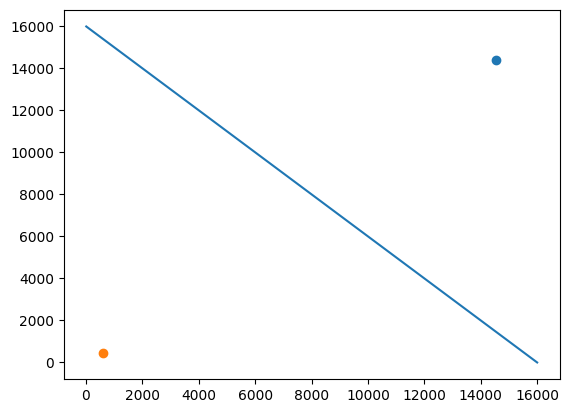

In [13]:
plt.plot(range(16000,0,-10),range(0,16000,10))
plt.scatter(json.loads(list_match_timeline_data_whereMid[0][1])['frames'][0]['participantFrames']['7']['position']['x'], json.loads(list_match_timeline_data_whereMid[0][1])['frames'][0]['participantFrames']['7']['position']['y'])
plt.scatter(json.loads(list_match_timeline_data_whereMid[0][1])['frames'][0]['participantFrames']['2']['position']['x'], json.loads(list_match_timeline_data_whereMid[0][1])['frames'][0]['participantFrames']['2']['position']['y'])

## Ward positions charts

### Bubble chart test

In [50]:
class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return np.argmin(distance, keepdims=True)

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')

In [ ]:
from collections import Counter
champion_list = data['champion']
count_champs = Counter(champion_list)
#print(count_champs)

Counter({'Smolder': 76, 'Aurora': 51, 'Syndra': 48, 'Sylas': 41, 'Hwei': 40, 'Jayce': 38, 'Orianna': 25, 'Taliyah': 25, 'Veigar': 24, 'Yone': 13, 'Vex': 13, 'Ahri': 13, 'AurelionSol': 11, 'Galio': 11, 'Zoe': 8, 'Ziggs': 8, 'Tristana': 7, 'Diana': 7, 'Akshan': 6, 'Corki': 6, 'Ryze': 5, 'Tryndamere': 5, 'Yasuo': 3, 'Garen': 3, 'Zeri': 3, 'Xerath': 2, 'TwistedFate': 2, 'Anivia': 1, 'Ezreal': 1, 'Lucian': 1, 'Lissandra': 1, 'Vladimir': 1, 'Jhin': 1, 'Neeko': 1, 'Akali': 1, 'Leblanc': 1, 'Nasus': 1, 'Sivir': 1})


In [52]:
import random

N = len(count_champs)

# liste de couleurs hexadécimales
liste_couleurs_hex = [f'#{random.randint(0, 0xFFFFFF):06X}' for _ in range(N)]


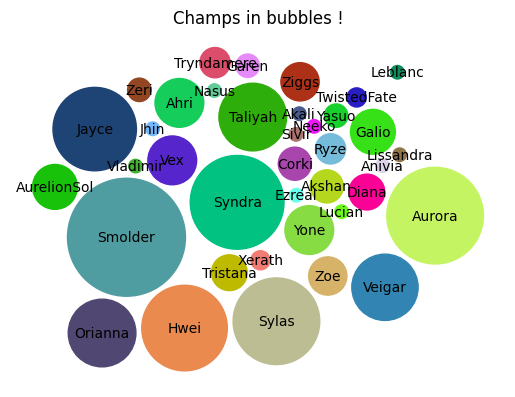

In [53]:

bubble_chart = BubbleChart(area=list((count_champs.values())),
                           bubble_spacing=0.5)

bubble_chart.collapse()


fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
bubble_chart.plot(
    ax, list((count_champs.keys())),liste_couleurs_hex)
ax.axis("off")
ax.relim()
ax.autoscale_view()
ax.set_title('Champs in bubbles !')

plt.show()

# Dash appli

In [54]:
def compute_metrics(player_data) :

    kda = player_data['kda'].mean()
    cs_min = player_data['cs/min'].mean()
    gold_diff = player_data['gold_diff@15'].mean()
    forward_percent = player_data['forward_%'].mean() * 100
    winrate_percent = (player_data['win'].value_counts().get(True,0) / len(player_data)) *100

    return {"kda" : kda, "cs_min" : cs_min, "gold_diff" : gold_diff, "forward_percent" : forward_percent, "winrate_percent" : winrate_percent}

In [55]:
from dash import html
def generate_kpi_cards(data):
    
    qing_metrics = compute_metrics(data)
    #avg_kills = data['kills'].mean() if not data.empty else 0
    avg_cs_min = qing_metrics['cs_min']
    avg_kda = qing_metrics['kda']
    avg_gold_diff = qing_metrics['gold_diff']
    avg_forward_percent = qing_metrics['forward_percent']
    winrate_percent = qing_metrics['winrate_percent']
    #KPI style creation
    return[
        html.Div(
            className="kpi-card",
            children=[
                html.H3("KDA"),
                html.H2(f"{avg_kda:.2f}")
            ]
        ),
        html.Div(
            className="kpi-card",
            children=[
                html.H3("CS/Min"),
                html.H2(f"{avg_cs_min:.2f}")
            ]),
            
        html.Div(
            className="kpi-card",
            children=[
                html.H3("Gold diff @15"),
                html.H2(f"{avg_gold_diff:.2f}")
            ]),

        html.Div(
            className="kpi-card",
            children=[
                html.H3("Forward %"),
                html.H2(f"{avg_forward_percent:.2f}")
            ]),

        html.Div(
            className="kpi-card",
            children=[
                html.H3("Winrate"),
                html.H2(f"{winrate_percent:.2f}")
            ])
    ]

In [114]:
#Hist champion winrates and games played

hist_champions_winrates = px.histogram(x=data['champion'], color=data['win'], barmode='group',color_discrete_sequence=px.colors.qualitative.Set1, title="List of champions win and lose",
                   labels={
                       "x" : "Champions",
                       "color" : "Win"
                   }).update_xaxes(categoryorder='total descending')



# radar chart with faker
import plotly.graph_objects as plty_go
def create_radar(qing,faker) :

    compare_categories = ['KDA', 'CS/Min','Gold diff @15','Forward %','Winrate']

    faker_radar = plty_go.Figure()

    qinq_metrics = compute_metrics(qing)
    faker_metrics = compute_metrics(faker)

    player_normalize_metrics = pd.DataFrame([qinq_metrics,faker_metrics])

    limit_params = {
        'kda' : (0,10),
        'cs_min' : (0,15),
        'gold_diff' : (-1000,1000),
        'forward_percent' : (0,100),
        'winrate_percent' : (0,100)
    }

    for col, (min_limit,max_limit) in limit_params.items() :
        player_normalize_metrics[col] = (player_normalize_metrics[col]-min_limit) / (max_limit-min_limit)

    faker_radar.add_trace(plty_go.Scatterpolar(
        r=player_normalize_metrics.iloc[0],
        theta=compare_categories,
        name="Qing",
        fill='toself',
        fillcolor=None
    ))

    faker_radar.add_trace(plty_go.Scatterpolar(
        r=player_normalize_metrics.iloc[1],
        theta=compare_categories,
        name="Faker",
        fill='toself'
    ))

    return faker_radar


In [134]:
app = dash.Dash("nom")

app.layout = dash.html.Div(style={
        "display": "flex",
        "flexDirection": "column",
        "padding": "20px",
        "fontFamily": "Roboto, sans-serif",
        "backgroundColor": "#f7f7f7"
    },children=[
    dash.dcc.Dropdown(list(count_champs.keys()), id="filter_dataframe", multi=True, placeholder="Filter on a champion", value=[]),


    #components
    dash.dash_table.DataTable(
        id='table',
        columns=[{"name" : i , "id" : i} for i in data.columns],
        data=data.to_dict('records'),
        filter_action="native",
        sort_action="native",  #tri
        page_size=10, 
        style_table={'marginBottom': '20px'},
        style_header={'backgroundColor': '#6e7c76', 'color': 'white', 'textAlign': 'center'},
        style_cell={
            'fontFamily' : "Roboto, sans-serif"
        },
        style_data={'border': '1px solid #ddd'}

    ),

    dash.html.Div(id="kpi_cards", style={'display': 'flex', 'gap': '20px', 'fontFamily' : 'Roboto, sans-serif', "justifyContent": "center" ,"alignItems" : "center" ,"fontWeight": "bold"}),
    dash.dcc.Graph(figure=create_radar(data,faker_data), id="faker_radar"),

    dash.dcc.Graph(figure=hist_champions_winrates)

])

#Callback filtering dataframe
@dash.callback(
        dash.Output("table","data"),
        dash.Input("filter_dataframe","value")
)
def filter_dataframe_and_update(filter_value):
    if not filter_value:  #df de base
        return data.to_dict('records')
    #filter
    filtered_df = data[data['champion'].isin(filter_value)]
    return filtered_df.to_dict('records')

#Callback  updating kpi number bellow df
@dash.callback(
        dash.Output("kpi_cards","children"),
        dash.Input("table","data")
)
def update_kpi(filter_data):
    filter_df = pd.DataFrame(filter_data)
    return generate_kpi_cards(filter_df)

#callback updating radar chart
@dash.callback(
    dash.Output("faker_radar","figure"),
    dash.Input("filter_dataframe","value")
)
def update_radar(champions):
    if not champions :
        return create_radar(data,faker_data)
    
    qing = data.loc[data['champion'].isin(champions)]
    faker = faker_data.loc[faker_data['champion'].isin(champions)]
    if qing.empty or faker.empty:
        return plty_go.Figure().add_trace(plty_go.Scatterpolar())
    return create_radar(qing,faker)




app.run_server(debug=True)

In [58]:
# add ward map
# compare with faker maybe (spider/radar chart)